# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [2]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Jesper Ekstrøm"
STUDENT_1_STUDENT_NUMBER = "5900468"
STUDENT_1_NETID = "jekstrom"
STUDENT_1_EMAIL = "J.Ekstrom@student.tudelft.nl"

In [3]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 1.0 - Generate the datasets (0p)

**Authors:** Tomás Coleman (T.Coleman@tudelft.nl), Chuhan Zhang (C.Zhang-8@tudelft.nl)

### Training data for tasks 1.1-1.4

In order to train the model, we require data. Therefore, we generate images of the robot at various positions in its state space. 
At every position chosen in the state space, an RGB image with dimensions 32x32x3, is generated as observation data $x$ together with the corresponding robot state $s=(\theta, \dot{\theta})$, where $\theta = [\theta_1, \theta_2]$ are the link angles of the robot, and $\dot{\theta} = [\dot{\theta_1}, \dot{\theta_2}]$ are the link angular velocities of the robot. 
The angle $\theta_1$ of link 1 and $\theta_2$ of link 2 are both defined with respect to the right horizontal position (or x-axis), both are wrapped to the $[-\pi, \pi]$ domain. 

We also generate a test set, which are observations of the robot sampled at every $2^{\circ}$, of the first link and at every $2^{\circ}$ of the second link for every sample of the first, giving 32400 (180x180) observations. 

Run the cells below to generate the data needed for the problems in `task_1b_train_NN.ipynb`.

**This notebook is not graded but is required for all tasks of problem 1.**

**Please do __not__ include the datasets of Problem 1 in your final submission!** I.e. exclude the `source/problem_1/datasets` folder from your ZIP archive.

In [4]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax.config import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import jit, lax, random
from jax import numpy as jnp
import numpy as onp
import cv2
from matplotlib import rcParams
import matplotlib.pyplot as plt
import os
from pathlib import Path
from progressbar import progressbar
from typing import Dict, Tuple
import shutil
import torch

from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.kinematics import forward_kinematics
from jax_double_pendulum.utils import normalize_link_angles
from utils import *


# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

# folder to save the dataset to
datasets_folder = Path("datasets")
datasets_folder.mkdir(exist_ok=True, parents=True)

# create directory for plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

## Generating dataset of state images 

### Training data for tasks 1.1-1.4

In order to train the model, we require data. Therefore, we generate images of the robot at various positions in its state space. 
At every position chosen in the state space, an RGB image with dimensions 32x32x3, is generated as observation data $x$ together with the corresponding robot state $s=(\theta, \dot{\theta})$, where $\theta = [\theta_1, \theta_2]$ are the link angles of the robot, and $\dot{\theta} = [\dot{\theta_1}, \dot{\theta_2}]$ are the link angular velocities of the robot. 
The angle $\theta_1$ of link 1 and $\theta_2$ of link 2 are both defined with respect to the right horizontal position (or x-axis), both are wrapped to the $[-\pi, \pi]$ domain. 

#### Training data

The training data constists of 20,000 images of the robot with link angles that are randomly sampled from the state space. 
- The link angles are first sampled and saved into the dataset with the label `th_curr_ss` to be used later as the ground truth labels. 
- From these angles, the robot is rendered into the 32x32x3 RGB images. Link 1 is blue and link 2 is red.

#### Test data
We also generate a test set, which are again 32x32x3 image observations of the robot sampled at every $2^{\circ}$, of the first link and at every $2^{\circ}$ of the second link for every sample of the first, giving 32400 (180x180) observations. Having a test data set larger than the training set is unusual in practice as we want our model to have as much data to train on in practice. As this is a training excercise (for you and the neural networks :), we generate this large test set over the state space so you can fully analyse the performance of the trained Neural Networks.

Run the cells below to generate the data needed for the problems in `task_1b_train_NN.ipynb`.

In [5]:
@jit
def save_test_data_to_dataset(
    _dataset: Dict[str, jnp.ndarray],
    initial_conditions: jnp.array,
) -> Dict[str, jnp.ndarray]:
    """
    puts the robot angle and x-y joint position in the dataset
    """
    num_ic = initial_conditions.shape[0]
    _dataset["th_curr_ss"] = _dataset["th_curr_ss"].at[:].set(initial_conditions)

    # Gets the robot elbow and end effector x-y coordinates from the 'forward_kinematics' function
    def _for_loop_cart_fun(idx, _dataset: Dict):
        _x_eb, _x = forward_kinematics(ROBOT_PARAMS, _dataset["th_curr_ss"][idx])
        _dataset["x_eb_ts"] = _dataset["x_eb_ts"].at[idx].set(_x_eb)
        _dataset["x_ts"] = _dataset["x_ts"].at[idx].set(_x)
        return _dataset

    _dataset = lax.fori_loop(
        lower=0, upper=num_ic, body_fun=_for_loop_cart_fun, init_val=_dataset
    )

    return _dataset

In [6]:
def save_image_data_to_dataset(
    _dataset: Dict[str, jnp.ndarray], ROBOT_PARAMS: Dict[str, jnp.ndarray]
) -> Dict[str, jnp.ndarray]:
    """
    This function calls the 'draw_robot' function to draw the image
    of the robot at each given theta values and returns the given 
    dataset with these drawn images corresponding to given angles
    """
    _dataset = draw_robot(_dataset, ROBOT_PARAMS)

    return _dataset

In [7]:
def save_image_data_to_dataset_snn(
    _dataset: Dict[str, jnp.ndarray], ROBOT_PARAMS: Dict[str, jnp.ndarray]
) -> Dict[str, jnp.ndarray]:
    _dataset = draw_robot_snn(_dataset, ROBOT_PARAMS)

    return _dataset

In [8]:
# Set seed so everyone has the same "random" training dataset
onp.random.seed(42)

# simulation parameters
num_samples_train = 20000
img_size = 32

# Sample the state space of -pi to pi for both robot links 
training_angles_sampled = onp.random.uniform(-onp.pi, onp.pi, [num_samples_train, 2])

# Generate test data: 180 x 180 images to evenly cover the state space
th1_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 90.0)
th2_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 90.0)

test_angles = jnp.array(jnp.meshgrid(th1_range, th2_range)).T.reshape(-1, 2)

num_samples_test = len(th1_range) * len(th2_range)

# initialise the train and test datasets with the appropriate sized arrays
# for the link angles "th_curr_ss", x-y elbow position "x_eb_ts", 
# x-y end effector position "x_ts" and the rendered image of the 
# robot at "th_curr_ss"
training_dataset = {
    "th_curr_ss": jnp.zeros((num_samples_train, 2)),
    "x_eb_ts": jnp.zeros((num_samples_train, 2)),
    "x_ts": jnp.zeros((num_samples_train, 2)),
    "th_pix_curr": jnp.zeros(
        (num_samples_train, img_size, img_size, 3), dtype=jnp.uint8
    ),
}

test_dataset = {
    "th_curr_ss": jnp.zeros((num_samples_test, 2)),
    "x_eb_ts": jnp.zeros((num_samples_test, 2)),
    "x_ts": jnp.zeros((num_samples_test, 2)),
    "th_pix_curr": jnp.zeros(
        (num_samples_test, img_size, img_size, 3), dtype=jnp.uint8
    ),
}

# input the initial values in the dataset
training_dataset = save_test_data_to_dataset(training_dataset, training_angles_sampled)
test_dataset = save_test_data_to_dataset(test_dataset, test_angles)

print("Rendering images of the robot for the training set ...")
training_dataset = save_image_data_to_dataset(training_dataset, ROBOT_PARAMS)

print("Rendering images of the robot for the test set ...")
test_dataset = save_image_data_to_dataset(test_dataset, ROBOT_PARAMS)

  0% (12 of 20000) |                     | Elapsed Time: 0:00:00 ETA:   0:02:47

Rendering images of the robot for the training set ...


100% (20000 of 20000) |##################| Elapsed Time: 0:01:09 Time:  0:01:09
  0% (18 of 32400) |                     | Elapsed Time: 0:00:00 ETA:   0:03:00

Rendering images of the robot for the test set ...


100% (32400 of 32400) |##################| Elapsed Time: 0:01:51 Time:  0:01:51


In [9]:
# Now save the dataset to a file so we can access it in the notebook for tasks 1.1-1.4
jnp.savez(
    file=str(datasets_folder / "dataset_double_pendulum_train.npz"), **training_dataset
)
jnp.savez(file=str(datasets_folder / "dataset_double_pendulum_test.npz"), **test_dataset)

In [10]:

def data_distribution(_theta):
    bin_no = 20
    heatmap, xedges, yedges = onp.histogram2d(_theta[:, 0], _theta[:, 1], bins=bin_no)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent)
    plt.colorbar()
    plt.xlabel("Link 1 angles (rad)")
    plt.ylabel("Link 2 angles (rad)")
    plt.title("Heat map of sample frequency in the state space")
    plt.show()

## Lets see what data we have got

Run the cells below to see the distribution of the train and test data set angles over the state space. You can see the training set has a far higher number of samples in some areas compared to others while the test set is evenly spread out. 

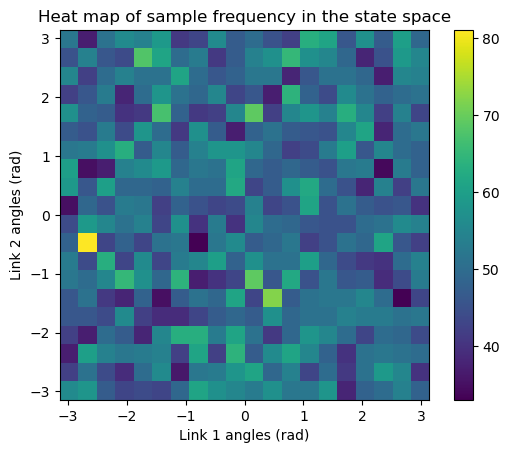

In [11]:
# show the distribution of training samples in the state space
data_distribution(training_dataset["th_curr_ss"])

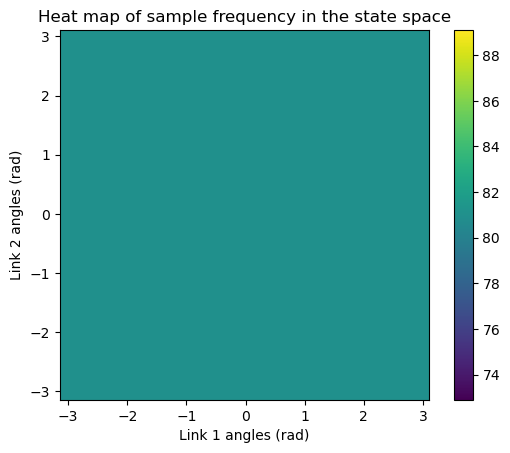

In [12]:
# shows the distribution of test samplesin the state space
data_distribution(test_dataset["th_curr_ss"])


Run the cells below to show what the rendered image of the robot actually looks like

index 7764
theta:  [0.17238601 0.09143977]


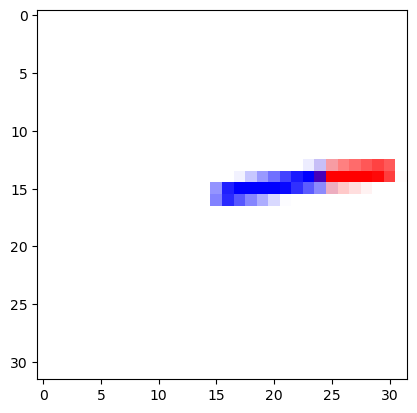

In [13]:
# Print a random image from the training dataset
index = onp.random.randint(0, num_samples_train)
print("index", index)
print("theta: ", training_dataset["th_curr_ss"][index])
plt.imshow(training_dataset["th_pix_curr"][index, :, :, :])

index 31296
theta:  [2.89724656 2.30383461]


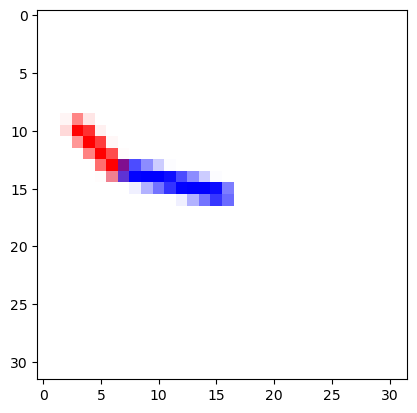

In [14]:
# Print a random image from the test dataset
index = onp.random.randint(0, 180 * 180)
print("index", index)
print("theta: ", test_dataset["th_curr_ss"][index])
plt.imshow(test_dataset["th_pix_curr"][index, :, :, :])

## Generating simulated event-based dataset

A simulated event-based image of a double pendulum is generated in the following cell, which is used for the training part in task 1.5. We use the same framework as in the RGB image generation section in the previous steps. However, event-based data requires the image itself and its dynamic transformation in continuous time. Therefore, we need to generate more data than in the previous parts.

In [15]:
@jit
def save_sim_data_to_dataset_snn(
    _dataset: Dict[str, jnp.ndarray],
    _sim_idx: int,
    _sim_ts: Dict[str, jnp.ndarray],
) -> Dict[str, jnp.ndarray]:
    _dataset["th_curr_ss"] = (
        _dataset["th_curr_ss"].at[_sim_idx].set(_sim_ts["th_ts"][0])
    )

    _dataset["th_d_curr_ss"] = (
        _dataset["th_d_curr_ss"].at[_sim_idx].set(_sim_ts["th_d_ts"][0])
    )

    _dataset["x_eb_ts"] = _dataset["x_eb_ts"].at[_sim_idx].set(_sim_ts["x_eb_ts"][0])
    _dataset["x_ts"] = _dataset["x_ts"].at[_sim_idx].set(_sim_ts["x_ts"][0])

    # Windowed data for SNN
    _dataset["th_window_snn"] = (
        _dataset["th_window_snn"].at[_sim_idx, :, :].set(_sim_ts["th_ts"])
    )

    _dataset["th_d_window_snn"] = (
        _dataset["th_d_window_snn"].at[_sim_idx, :, :].set(_sim_ts["th_d_ts"])
    )

    _dataset["x_eb_ts_window_snn"] = (
        _dataset["x_eb_ts_window_snn"].at[_sim_idx, :, :].set(_sim_ts["x_eb_ts"])
    )
    _dataset["x_ts_window_snn"] = (
        _dataset["x_ts_window_snn"].at[_sim_idx, :, :].set(_sim_ts["x_ts"])
    )
    return _dataset


@jit
def generate_data_point(ic, _rng, _t_ts):
    """
    Generates a data point for the state of the robot from a given angle.

    """

    # for ic_idx in range(initial_conditions, 1):

    _rng, subkey1, subkey2 = random.split(_rng, 3)

    max_th_d = 1 * jnp.pi

    _th_d_0 = onp.array([max_th_d, max_th_d])
    _sim_ts = simulate_robot(rp=ROBOT_PARAMS, t_ts=_t_ts, th_0=ic, th_d_0=_th_d_0)
    return _sim_ts, _rng

A train set and a test set are saved separately in the following cell. We could use the `train/test_th1/2_range` parameter to adjust the links' simulation range, which also affects the amount of generated data. Currently, it could generate 120 groups of training data and 120 groups of test data randomly. For each dataset, it contains 1010 continuous-time images, which will be used in the subsequent step of converting to event-based data. Due to the time-consuming steps of rendering and saving images (currently 15-20 minutes to generate two datasets), we do not recommend generating very large datasets or using larger image sizes.

In [16]:
# initialize random number generator
key = random.PRNGKey(seed=42)

# simulation parameters
sim_duration = 5.05
sim_dt = 5e-3
img_size = 32
# Since the big O is not good compared to the size of dataset,
# Run this multiple times for different sections of the first link,
# then bring them together in the training file.
train_th1_range = jnp.arange(-jnp.pi / 6.0, jnp.pi / 6.0, jnp.pi / 30.0)
train_th2_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 6.0)
test_th1_range = jnp.arange(-jnp.pi / 6.0, jnp.pi / 6.0, jnp.pi / 30.0)
test_th2_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 6.0)


# initial_conditions = jnp.array([th_range, th_range])
train_initial_conditions = jnp.array(
    jnp.meshgrid(train_th1_range, train_th2_range)
).T.reshape(-1, 2)
test_initial_conditions = jnp.array(
    jnp.meshgrid(test_th1_range, test_th2_range)
).T.reshape(-1, 2)

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# set global variables
TRAIN_NUM_DATA = len(train_th1_range) * len(train_th2_range)
TEST_NUM_DATA = len(test_th1_range) * len(test_th2_range)
NUM_SNN_DATA = 5


trainset = {
    "dt_ss": sim_dt * jnp.ones(TRAIN_NUM_DATA, dtype=jnp.float32),
    "th_curr_ss": jnp.zeros((TRAIN_NUM_DATA, 2), dtype=jnp.float32),
    "th_window_snn": jnp.zeros((TRAIN_NUM_DATA, 1010, 2), dtype=jnp.float32),
    "th_d_curr_ss": jnp.zeros((TRAIN_NUM_DATA, 2), dtype=jnp.float32),
    "th_d_window_snn": jnp.zeros((TRAIN_NUM_DATA, 1010, 2), dtype=jnp.float32),
    "x_eb_ts": jnp.zeros((TRAIN_NUM_DATA, 2), dtype=jnp.float32),
    "x_ts": jnp.zeros((TRAIN_NUM_DATA, 2), dtype=jnp.float32),
    "x_eb_ts_window_snn": jnp.zeros((TRAIN_NUM_DATA, 1010, 2), dtype=jnp.float32),
    "x_ts_window_snn": jnp.zeros((TRAIN_NUM_DATA, 1010, 2), dtype=jnp.float32),
    "th_pix_curr": jnp.zeros(
        (TRAIN_NUM_DATA, img_size, img_size, 3), dtype=jnp.float32
    ),
    "th_pix_window_snn": jnp.zeros(
        (TRAIN_NUM_DATA, 1010, img_size, img_size, 3), dtype=jnp.float32
    ),
}
testset = {
    "dt_ss": sim_dt * jnp.ones(TEST_NUM_DATA, dtype=jnp.float32),
    "th_curr_ss": jnp.zeros((TEST_NUM_DATA, 2), dtype=jnp.float32),
    "th_window_snn": jnp.zeros((TEST_NUM_DATA, 1010, 2), dtype=jnp.float32),
    "th_d_curr_ss": jnp.zeros((TEST_NUM_DATA, 2), dtype=jnp.float32),
    "th_d_window_snn": jnp.zeros((TEST_NUM_DATA, 1010, 2), dtype=jnp.float32),
    "x_eb_ts": jnp.zeros((TEST_NUM_DATA, 2), dtype=jnp.float32),
    "x_ts": jnp.zeros((TEST_NUM_DATA, 2), dtype=jnp.float32),
    "x_eb_ts_window_snn": jnp.zeros((TEST_NUM_DATA, 1010, 2), dtype=jnp.float32),
    "x_ts_window_snn": jnp.zeros((TEST_NUM_DATA, 1010, 2), dtype=jnp.float32),
    "th_pix_curr": jnp.zeros((TEST_NUM_DATA, img_size, img_size, 3), dtype=jnp.float32),
    "th_pix_window_snn": jnp.zeros(
        (TEST_NUM_DATA, 1010, img_size, img_size, 3), dtype=jnp.float32
    ),
}

print("Generating simulation data for the SNN training set ...")
for sim_idx in progressbar(range(TRAIN_NUM_DATA)):
    sim_ts, key = generate_data_point(train_initial_conditions[sim_idx], key, t_ts)
    trainset = save_sim_data_to_dataset_snn(trainset, sim_idx, sim_ts)
    
print("Generating simulation data for the SNN test set ...")
for sim_idx in progressbar(range(TEST_NUM_DATA)):
    sim_ts, key = generate_data_point(test_initial_conditions[sim_idx], key, t_ts)
    testset = save_sim_data_to_dataset_snn(testset, sim_idx, sim_ts)

print("Rendering images of the robot for the SNN training set ...")
trainset = save_image_data_to_dataset_snn(trainset, ROBOT_PARAMS)
print("Rendering images of the robot for the SNN test set ...")
testset = save_image_data_to_dataset_snn(testset, ROBOT_PARAMS)

print(f"Start save the images to the file:")
jnp.savez(
    file=str(datasets_folder / "dataset_double_pendulum_snn_train.npz"), **trainset
)
jnp.savez(file=str(datasets_folder / "dataset_double_pendulum_snn_test.npz"), **testset)
print(f"save successfully!")

  0% (0 of 120) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Generating simulation data for the SNN training set ...


/home/jesperek/programs/miniconda3/envs/ics/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
100% (120 of 120) |######################| Elapsed Time: 0:00:33 Time:  0:00:33
  0% (0 of 120) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Generating simulation data for the SNN test set ...


100% (120 of 120) |######################| Elapsed Time: 0:00:37 Time:  0:00:37
  0% (0 of 120) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Rendering images of the robot for the SNN training set ...


100% (120 of 120) |######################| Elapsed Time: 0:08:17 Time:  0:08:17
  0% (0 of 120) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Rendering images of the robot for the SNN test set ...


100% (120 of 120) |######################| Elapsed Time: 0:08:22 Time:  0:08:22


Start save the images to the file:
save successfully!


### Transfer RGB image data into simulated event-based data

We got training and test set in the previous generation step. Each dataset contains 120 consecutive sets of still images. Each set contains 1010 images. In the following steps, we will use these static images to simulate event-based data.

Event-based data can only capture pixel changes. We will compare every two consecutive images. If the pixel goes from dark to bright, the event data of the first channel is set to 1. Conversely, if the pixel goes from bright to dark, the second channel's event data is set to 1. To capture noticeable pixel changes, we sample these 1010 images at intervals of 10. Ultimately, we can get 101 static images, which means we will get 100 event-based data containing pixel changes. We use 20 as the time step for each event-based data. Finally, we could obtain five event-based data from each group. The size of generated event-based data is: `[time_step: 20, channels: 2, size: 32, size: 32]`. They could be fed directly to SNNs.

These event-based data will be saved seperately in the files named `train` and `test` in .pt format. In the following steps, we will use `torch.load()` method to read them.

In [17]:
def trainset_transform_to_snn(datasets_folder):
    velocity, observation = read_data(
        str(datasets_folder / "dataset_double_pendulum_snn_train.npz")
    )

    snn_data = generate_snn_data(observation, TRAIN_NUM_DATA, NUM_SNN_DATA)
    train_set_dir = datasets_folder / "event_based_data" / "train"
    if train_set_dir.exists():
        if os.path.getsize(train_set_dir) == 0:
            os.removedirs(train_set_dir)
        else:
            shutil.rmtree(train_set_dir)
    os.makedirs(train_set_dir)

    divide_and_save_data(snn_data, velocity, TRAIN_NUM_DATA, NUM_SNN_DATA, train_set_dir)


def testset_transform_to_snn(datasets_folder):
    velocity, observation = read_data(
        str(datasets_folder / "dataset_double_pendulum_snn_test.npz")
    )

    snn_data = generate_snn_data(observation, TEST_NUM_DATA, NUM_SNN_DATA)
    test_set_dir = datasets_folder / "event_based_data" / "test"
    if test_set_dir.exists():
        if os.path.getsize(test_set_dir) == 0:
            os.removedirs(test_set_dir)
        else:
            shutil.rmtree(test_set_dir)
    os.makedirs(test_set_dir)

    divide_and_save_data(snn_data, velocity, TEST_NUM_DATA, NUM_SNN_DATA, test_set_dir)

In [18]:
print(f"Transform RGB sequential images into event-based data")
trainset_transform_to_snn(datasets_folder)
testset_transform_to_snn(datasets_folder)
print(f"Finished!")

Transform RGB sequential images into event-based data
Finished!


### Show examples of SNN data

Two examples of event-based data are printed as `.gif` in this section. The yellow and purple edges represent two channels in the event-based data. We can see how the pendulum changes during these 20 time steps. Therefore, the temporal characteristics of event-based data are implied in it. SNN will process this data in the form of recurrent.

51


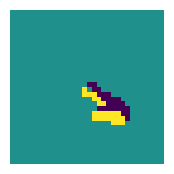

In [19]:
# Print a random SNN data from the training dataset

index = onp.random.randint(0, TRAIN_NUM_DATA * NUM_SNN_DATA)
print(index)
spike = torch.load(
    str(datasets_folder / "event_based_data" / "train" / f"spike{int(index)}.pt")
)
snn_animation(spike, str(outputs_dir / "snn_train_example.gif"))

2


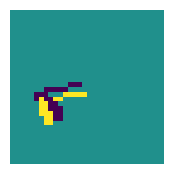

In [20]:
# Print a random SNN data from the test dataset

index = onp.random.randint(0, TEST_NUM_DATA * NUM_SNN_DATA)
print(index)
spike = torch.load(
    str(datasets_folder / "event_based_data" / "test" / f"spike{int(index)}.pt")
)
snn_animation(spike, str(outputs_dir / "snn_test_example.gif"))